In [ ]:
%%capture
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [ ]:
from fenics import *
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from mshr import *
from numpy import log, exp

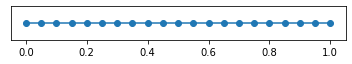

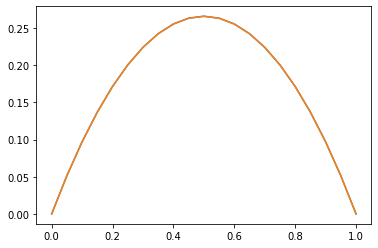

In [ ]:
#1D scalar problem
# -u'' + u = f(x), 0 < x < 1,   u(0) = 0,  u(1) = 0
# Weak form \int (u'w' + uw)dx = \int fwdx, 

n = 20  # number of mesh elements
deg =1     # Polynomial order of trial/test functions
errors = []  # list into which to store the errors
# Define the exact solution for later use
uexact = Expression('(exp(-1.0)-1.0)*(exp(x[0])-1.0) + (1-exp(1.0))*(exp(-x[0])-1.0)',degree=deg+2)

# Define the boundary
xl = 0 # Left end point
xr = 1 # Right end point
mesh = IntervalMesh(n,xl,xr)
# plot(mesh)


V = FunctionSpace(mesh, 'CG', deg)
# Define a boundary value at the left and right end points
ub = Constant(0.)
# Define the portion of the boundary at which the Dirichlet BC is imposed
def Dirichlet_boundary(x,on_boundary):
    return x[0] < DOLFIN_EPS or x[0] > 1 - DOLFIN_EPS and on_boundary

bc = DirichletBC(V,ub,Dirichlet_boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(exp(1.0) - exp(-1.0))
a = inner(grad(u),grad(v))*dx + u*v*dx
L = f*v*dx

# Solve the discrete equations for the function uh in V
uh = Function(V)  # declares uh as a finite element function in the space V
solve(a == L, uh, bc)

plt.figure()
plot(mesh)

#Exact solution, interpolated using the function space
ue = interpolate(uexact, V)
plt.figure()
plot(uh)
plot(ue)


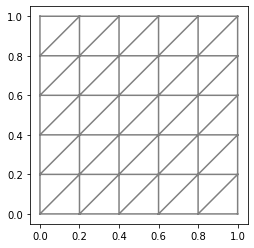

In [ ]:
#Scalar 2D

mesh = UnitSquareMesh(5, 5)
plot(mesh)
V = FunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)
for i, cell in enumerate(cells(mesh)):
    if i==1: # for the second element
        A = assemble_local(inner(grad(u), grad(v)) *dx, cell)  # A is the local stiffness

# print(A)

K=assemble(inner(grad(u), grad(v)) *dx).array()
# print(K)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


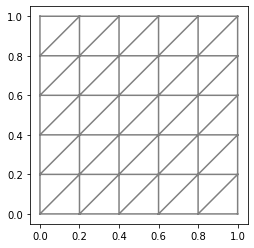

In [ ]:
#Elasticity 2D
#https://comet-fenics.readthedocs.io/en/latest/demo/elasticity/2D_elasticity.py.html

mesh = UnitSquareMesh(5, 5)
plot(mesh)


def eps(v):
  return sym(grad(v))

E = Constant(1e5)
nu = Constant(0.3)
model = "plane_stress"
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
if model == "plane_stress":
  lmbda = 2*mu*lmbda/(lmbda+2*mu)

def sigma(v):
  return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

rho_g = 1e-3
f = Constant((0,-rho_g))
V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)
du = TrialFunction(V)
u_ = TestFunction(V)

K=assemble(inner(sigma(du), eps(u_))*dx).array()
print(K-K.T)

Maximal deflection: 0.0058637539429870714
Beam theory deflection: 0.005859375


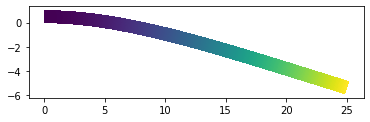

In [ ]:
L = 25.
H = 1.
Nx = 250
Ny = 10
mesh = RectangleMesh(Point(0., 0.), Point(L, H), Nx, Ny, "crossed")

# plot(mesh)

def eps(v):
  return sym(grad(v))

E = Constant(1e5)
nu = Constant(0.3)
model = "plane_stress"
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
if model == "plane_stress":
  lmbda = 2*mu*lmbda/(lmbda+2*mu)

def sigma(v):
  return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

rho_g = 1e-3
f = Constant((0,-rho_g))
V = VectorFunctionSpace(mesh, 'Lagrange', degree=2)
du = TrialFunction(V)
u_ = TestFunction(V)
a = inner(sigma(du), eps(u_))*dx
l = inner(f, u_)*dx

def left(x, on_boundary):
  return near(x[0],0.)

bc = DirichletBC(V, Constant((0.,0.)), left)
u = Function(V, name="Displacement")
solve(a == l, u, bc)
plot(1e3*u, mode="displacement")

print("Maximal deflection:", -u(L,H/2.)[1])
print("Beam theory deflection:", float(3*rho_g*L**4/2/E/H**3))

Eigenfrequency:  6.28421 [rad]


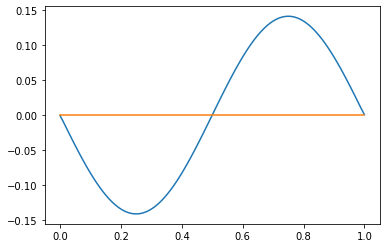

In [ ]:

import fenics as fe
#String vibration
# (Tu')'= -w^2*rho*u
#Weak form: \int (Tu'w')dx = w^2 \int (rho*u*w)dx

# --------------------
# Parameters
# --------------------
T = 1.0
rho = 1.0

n = 100  # number of mesh elements
deg =1     # Polynomial order of trial/test functions

# Define the boundary
xl = 0 # Left end point
xr = 1 # Right end point
mesh = IntervalMesh(n,xl,xr)
V = FunctionSpace(mesh, 'CG', deg)
# Define a boundary value at the left and right end points
ub = Constant(0.)
# Define the portion of the boundary at which the Dirichlet BC is imposed
def Dirichlet_boundary(x,on_boundary):
    return x[0] < DOLFIN_EPS or x[0] > 1 - DOLFIN_EPS and on_boundary

bc = DirichletBC(V,ub,Dirichlet_boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)

# --------------------
# Forms & matrices
# --------------------
a_form = T*inner(grad(u), grad(v))*dx
m_form = rho*inner(u,v)*dx
#Useless matrix; only to satisfy the syntax requirements of assemble_system
L = Constant(0.0)*v*dx

A = PETScMatrix()
M = PETScMatrix()

A,_ = assemble_system(a_form, L, bc)
M = assemble(m_form, tensor=M)


# --------------------
# Eigen-solver
# --------------------

eigensolver = SLEPcEigenSolver(as_backend_type(A), as_backend_type(M))
prm = eigensolver.parameters
info(prm, True)
eigensolver.parameters['spectrum'] = 'smallest magnitude'

N_eig = 10   # number of eigenvalues
eigensolver.solve(N_eig)

# Eigenfrequencies
for i in range(N_eig):
    # Get i-th eigenvalue and eigenvector
    # r - real part of eigenvalue
    # c - imaginary part of eigenvalue
    # rx - real part of eigenvector
    # cx - imaginary part of eigenvector
    r, c, rx, cx = eigensolver.get_eigenpair(i)

    # Calculation of eigenfrequency from real part of eigenvalue
    # freq_3D = fe.sqrt(r)/2/fe.pi
    print("Eigenfrequency: {0:8.5f} [rad]".format(fe.sqrt(r)))
    # print("Eigenfrequency: {0:8.5f} [Hz]".format(freq_3D))

i=1
r, c, rx, cx = eigensolver.get_eigenpair(i)

print("Eigenfrequency: {0:8.5f} [rad]".format(fe.sqrt(r)))
eigenmodeR = fe.Function(V, name="Eigenvector " + str(i))
eigenmodeR.vector()[:] = rx
eigenmodeI = fe.Function(V, name="Eigenvector " + str(i))
eigenmodeI.vector()[:] = cx

plot(eigenmodeR,backend="matplotlib")
plot(eigenmodeI,backend="matplotlib")

In [ ]:
# https://fenics-solid-tutorial.readthedocs.io/en/latest/EigenvalueProblem/EigenvalueProblem.html
#Not working right now

import fenics as fe
# --------------------
# Functions and classes
# --------------------
# Strain function
def epsilon(u):
    return 0.5*(fe.nabla_grad(u) + fe.nabla_grad(u).T)

# Stress function
def sigma(u):
    return lmbda*fe.div(u)*fe.Identity(3) + 2*mu*epsilon(u)

# --------------------
# Parameters
# --------------------
# Young modulus, poisson number and density
E, nu = 70.0E9, 0.23
rho = 2500.0

# Lame's constants
mu = E/2./(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)

l_x, l_y, l_z = 1.0, 1.0, 0.01  # Domain dimensions
n_x, n_y, n_z = 20, 20, 2  # Number of elements

# --------------------
# Geometry
# --------------------
mesh = fe.BoxMesh(fe.Point(0.0, 0.0, 0.0), fe.Point(l_x, l_y, l_z), n_x, n_y, n_z)

walls   = 'near(x[0], 0)'

# --------------------
# Function spaces
# --------------------
V = fe.VectorFunctionSpace(mesh, "CG", 2)
bc = DirichletBC(V, Constant((0.,0.,0.)), walls)

u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

# --------------------
# Forms & matrices
# --------------------
a_form = fe.inner(sigma(u_tr), epsilon(u_test))*fe.dx
m_form = rho*fe.inner(u_tr, u_test)*fe.dx

#Useless matrix; only to satisfy the syntax requirements of assemble_system
f = Constant((0,0,0))
L = fe.inner(f, u_test)*dx

A = PETScMatrix()
M = PETScMatrix()

A,_ = assemble_system(a_form, L, bc)
M = assemble(m_form, tensor=M)

# --------------------
# Eigen-solver
# --------------------
# eigensolver = fe.SLEPcEigenSolver(A, M)
# eigensolver.parameters['problem_type'] = 'gen_hermitian'
# eigensolver.parameters["spectrum"] = "smallest real"
# eigensolver.parameters['spectral_transform'] = 'shift-and-invert'
# eigensolver.parameters['spectral_shift'] = 100.0

eigensolver = SLEPcEigenSolver(as_backend_type(A), as_backend_type(M))
prm = eigensolver.parameters
info(prm, True)
eigensolver.parameters['spectrum'] = 'smallest magnitude'

N_eig = 12   # number of eigenvalues
eigensolver.solve(N_eig)

# --------------------
# Post-process
# --------------------
# Set up file for exporting results
file_results = fe.XDMFFile("MA.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

# Eigenfrequencies
for i in range(N_eig):
    # Get i-th eigenvalue and eigenvector
    # r - real part of eigenvalue
    # c - imaginary part of eigenvalue
    # rx - real part of eigenvector
    # cx - imaginary part of eigenvector
    r, c, rx, cx = eigensolver.get_eigenpair(i)

    # Calculation of eigenfrequency from real part of eigenvalue
    freq_3D = fe.sqrt(r)/2/fe.pi
    print("Eigenfrequency: {0:8.5f} [Hz]".format(freq_3D))

    # Initialize function and assign eigenvector
    eigenmode = fe.Function(V, name="Eigenvector " + str(i))
    eigenmode.vector()[:] = rx

    # Write i-th eigenfunction to xdmf file
    file_results.write(eigenmode, i)

RuntimeError: ignored

51.52553891864769


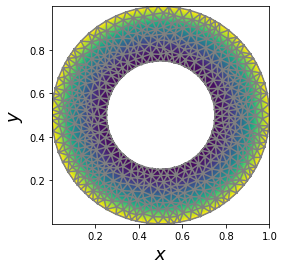

In [ ]:
#Circle inside a circle
#Vibration of a 2D acoustic shell

domain = Circle(Point(0.5,0.5), 0.5)-Circle(Point(0.5,0.5), 0.25)
mesh = generate_mesh(domain, 20)
plot(mesh)

# #Boundaries for the square problem
# walls   = 'near(x[1], 0) || near(x[1], 1) || near(x[0], 0) || near(x[0], 1)'

def inner_circle(x, on_boundary):
    tol = 1E-2
    r = np.sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2)
    return on_boundary and near(r, 0.25, tol)

def outer_circle(x, on_boundary):
    tol = 1E-2
    r = np.sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2)
    return on_boundary and near(r, 0.5, tol)

def solveeig(c):
    
    Vr = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    Vi = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    Vc = Vr*Vi
    Vz = FunctionSpace(mesh,Vc)

    # #Dirchlet on both inner and outer circles
    # bc1  = DirichletBC(Vz, Constant((0, 0)), inner_circle)
    # bc2  = DirichletBC(Vz, Constant((0, 0)), outer_circle)
    # bc = [bc1,bc2]

    #Dirchlet on only outer circle
    # bc1  = DirichletBC(Vz, Constant((0, 0)), inner_circle)
    bc2  = DirichletBC(Vz, Constant((0, 0)), outer_circle)
    bc = [bc2]

    (u_r, u_i) = TrialFunctions(Vz)
    (v_r, v_i) = TestFunctions(Vz)

    t1r=c**2*(inner(grad(u_r), grad(v_r))-inner(grad(u_i), grad(v_i)))
    t1i=c**2*(inner(grad(u_r), grad(v_i))+inner(grad(u_i), grad(v_r)))
    # Sum terms and define a useless term
    ar = t1r
    ai = t1i
    L = Constant(0.0)*(v_r+v_i)*dx

    # Overlap integral between test and trial functions
    m = (u_r*v_r - u_i*v_i + u_r*v_i + u_i*v_r)*dx

    A,_ = assemble_system((ar+ai)*dx, L, bc)
    B = assemble(m)
    
    eigensolver = SLEPcEigenSolver(as_backend_type(A), as_backend_type(B))
    prm = eigensolver.parameters
    info(prm, True)
    eigensolver.parameters['spectrum'] = 'smallest magnitude'

    eigensolver.solve()

    return eigensolver

c = 1
sol=solveeig(c)

n=0 # Eigenvalue to plot

Vr = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
Vi = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
Vc = Vr*Vi
Vz = FunctionSpace(mesh,Vc)
pressure = Function(Vz)
eig=pressure.vector()
eig[:]=sol.get_eigenpair(2*n)[2]

plot(pressure[0],backend="matplotlib")
plt.xlabel("$x$",fontsize=18)
plt.ylabel("$y$",fontsize=18)

print(sol.get_eigenpair(0)[0])

67.02236829175885


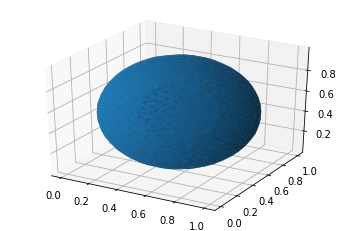

In [ ]:
#Vibration of a 3D sphere

domain = Sphere(Point(0.5,0.5,0.5), 0.5)-Sphere(Point(0.5,0.5,0.5), 0.25)
mesh = generate_mesh(domain, 20)
plot(mesh)


def inner_circle(x, on_boundary):
    tol = 1E-2
    r = np.sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2 + (x[2]-0.5)**2)
    return on_boundary and near(r, 0.25, tol)

def outer_circle(x, on_boundary):
    tol = 1E-2
    r = np.sqrt((x[0]-0.5)**2 + (x[1]-0.5)**2 + (x[2]-0.5)**2)
    return on_boundary and near(r, 0.5, tol)

def solveeig(c):
    
    Vr = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    Vi = FiniteElement("Lagrange", mesh.ufl_cell(), 1)

    Vc = Vr*Vi
    Vz = FunctionSpace(mesh,Vc)

    # #Dirchlet on both inner and outer circles
    # bc1  = DirichletBC(Vz, Constant((0, 0)), inner_circle)
    # bc2  = DirichletBC(Vz, Constant((0, 0)), outer_circle)
    # bc = [bc1,bc2]

    #Dirchlet on only outer circle
    # bc1  = DirichletBC(Vz, Constant((0, 0)), inner_circle)
    bc2  = DirichletBC(Vz, Constant((0, 0)), outer_circle)
    bc = [bc2]

    # #Both Neumann
    # bc = []

    (u_r, u_i) = TrialFunctions(Vz)
    (v_r, v_i) = TestFunctions(Vz)

    t1r=c**2*(inner(grad(u_r), grad(v_r))-inner(grad(u_i), grad(v_i)))
    t1i=c**2*(inner(grad(u_r), grad(v_i))+inner(grad(u_i), grad(v_r)))
    # Sum terms and define a useless term
    ar = t1r
    ai = t1i
    L = Constant(0.0)*(v_r+v_i)*dx

    # Overlap integral between test and trial functions
    m = (u_r*v_r - u_i*v_i + u_r*v_i + u_i*v_r)*dx

    A,_ = assemble_system((ar+ai)*dx, L, bc)
    B = assemble(m)
    
    eigensolver = SLEPcEigenSolver(as_backend_type(A), as_backend_type(B))
    prm = eigensolver.parameters
    info(prm, True)
    eigensolver.parameters['spectrum'] = 'smallest magnitude'

    eigensolver.solve()

    return eigensolver

c = 1
sol=solveeig(c)

n=0 # Eigenvalue to plot

Vr = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
Vi = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
Vc = Vr*Vi
Vz = FunctionSpace(mesh,Vc)
pressure = Function(Vz)
eig=pressure.vector()
eig[:]=sol.get_eigenpair(2*n)[2]

# plot(pressure[0],backend="matplotlib")
# plt.xlabel("$x$",fontsize=18)
# plt.ylabel("$y$",fontsize=18)

print(sol.get_eigenpair(0)[0])